The notebook is a practice attempt towards solving the `Titanic Survival dataset` from Kaggle. 
The source can be found at https://www.kaggle.com/startupsci/titanic-data-science-solutions/log

### The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to **build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data** (ie name, age, gender, socio-economic class, etc).

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier

from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

### Data

The data has been split into **two groups**:

The **training set** should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The **test set** should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

In [5]:
train_df = pd.read_csv('datasets/train.csv')
test_df = pd.read_csv('datasets/test.csv')
combine = [train_df, test_df]

### Analyzing the Data

**Which features are available in the dataset**

In [20]:
print(train_df.columns.values)
print("\nNumber of columns "+str(len(train_df.columns.values)))

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']

Number of columns 12


**Which features are categorical?**

Categorical - Survived, Sex, Embarked

Ordinal - Pclass

**Which features are numerical?**

Continous - Age and Fare

Discrete - SibSp and Parch

In [22]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Which features are mixed data types?**

Ticket is a mix of numeric and alphanumeric. Cabin is all alphanumeric

In [23]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


**Which features contain blank, null or empty values?**

Age, Cabin, Embarked contain a number of null values in the training data set

Cabin and Age contain number of null data in the test data set

In [24]:
train_df.info()
print("-"*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

**What is the distribution of the numerical features across the samples?**

In [25]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [26]:
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [28]:
train_df['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [31]:
train_df['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

- Total samples are 891 in count
- Survived is a categorical feature with values 0 and 1
- 38% of the people survived in the total dataset
- Roughly 32% of the total passengers had any siblings or spouse on board.
- Roughtly 75% of the passengers did not travel with parents or children

**What is the distribution of the categorical features?**

In [42]:
len(train_df['Name'].unique())

891

In [52]:
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [53]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [56]:
len(train_df['Ticket'].unique())

681

In [74]:
train_df.describe(include=['O']) #describes only the categorical values

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Hegarty, Miss. Hanora ""Nora""",male,1601,B96 B98,S
freq,1,577,7,4,644


In [81]:
train_df.describe(include=[np.int64, np.float64]) # describing the features specific to the data types given

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [67]:
train_df.Sex.describe() #describes only a specific features

count      891
unique       2
top       male
freq       577
Name: Sex, dtype: object

- Name is unique across the dataset as they are 891 in count
- Roughly 65% of the dataset are males
- Roughly 72% of the passengers embarked at S
- Ticket feature has a high ratio of duplicate values

In [124]:
train_df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


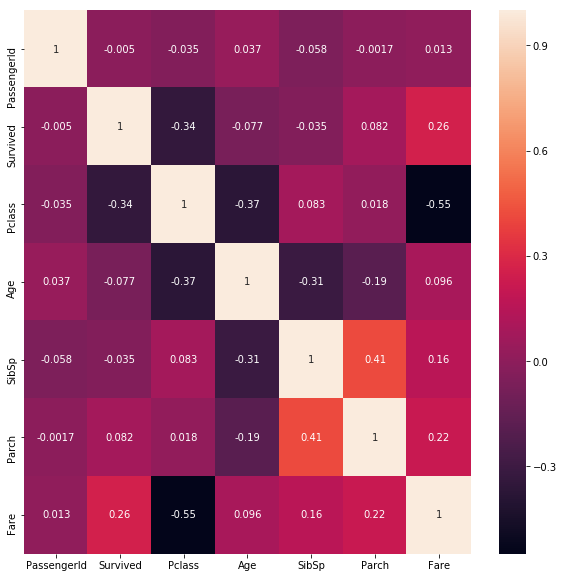

In [84]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(train_df.corr(), annot=True)

Calculating the mean survival data for each Passenger class

In [112]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [118]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [121]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='SibSp', ascending=True)

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


### Analyze by Visualizing data

In [154]:
train_df[['Age', 'Survived']].sort_values('Age', ascending=False).head(5)

,Age,Survived
630,80.0,1
851,74.0,0
493,71.0,0
96,71.0,0
116,70.5,0


In [155]:
bins = [0, 5, 15, 25, 35, 45, 55, 65, 75, 85]
names = ['<5', '5-15', '15-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75-85']

train_df['Range of Age'] = pd.cut(train_df['Age'], bins, labels=names)

In [156]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Range of Age
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,15-25
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,35-45
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,25-35
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,25-35
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,25-35


In [157]:
train_df[['Range of Age', 'Survived']].groupby(['Range of Age'], as_index=False).mean()

,Range of Age,Survived
0,<5,0.704545
1,5-15,0.461538
2,15-25,0.344037
3,25-35,0.423469
4,35-45,0.394737
5,45-55,0.412698
6,55-65,0.343750
7,65-75,0.000000
8,75-85,1.000000


In [165]:
train_df[['Range of Age', 'Name']].groupby(['Range of Age'], as_index=False).count().sort_values('Name', ascending=False)

,Range of Age,Name
2,15-25,218
3,25-35,196
4,35-45,114
5,45-55,63
0,<5,44
1,5-15,39
6,55-65,32
7,65-75,7
8,75-85,1


- Infants below age of 5 has the most survival rate
- Oldest passenger (aged 80) has survived
- Children between age groups of 15-25 had a low survival rate
- Most passengers are under the age range of 15 - 35

In [167]:
train_df = train_df.drop(['Range of Age'], axis=1)

### Wrangling data

**Correcting by dropping features**

- Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.

- Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.

- PassengerId may be dropped from training dataset as it does not contribute to survival.

- Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.

In [169]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before (891, 12) (418, 11) (891, 13) (418, 11)


In [183]:
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

"After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

KeyError: "['Ticket' 'Cabin'] not found in axis"

**Creating new feature extracting from existing**

We want to analyze if Name feature can be engineered to extract titles and test correlation between titles and survival, before dropping Name and PassengerId features.

In [192]:
for dataset in combine:
    dataset['Title'] = dataset['Name'].str.extract('([A-Za-z]+)\.', expand=False)


pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [193]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

In [194]:
dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [195]:
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Master,0,40
Miss,182,0
Mlle,2,0
Mme,1,0
Mr,0,517
Mrs,125,0
Ms,1,0
Rare,3,20


In [196]:
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.697802
2,Mlle,1.000000
3,Mme,1.000000
4,Mr,0.156673
5,Mrs,0.792000
6,Ms,1.000000
7,Rare,0.347826


Converting categorical titles to ordinal

In [197]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

In [198]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1.0


Now we can safely drop the Name feature from training and testing datasets. We also do not need the PassengerId feature in the training dataset.

In [199]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

**Converting a categorical feature**

In [200]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female':1, 'male':0}).astype(int)

In [201]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1.0
1,1,1,1,38.0,1,0,71.2833,C,3.0
2,1,3,1,26.0,0,0,7.9250,S,2.0
3,1,1,1,35.0,1,0,53.1000,S,3.0
4,0,3,0,35.0,0,0,8.0500,S,1.0


**Completing a numerical continuous feature**

In [202]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [203]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1.0
1,1,1,1,38,1,0,71.2833,C,3.0
2,1,3,1,26,0,0,7.9250,S,2.0
3,1,1,1,35,1,0,53.1000,S,3.0
4,0,3,0,35,0,0,8.0500,S,1.0


In [204]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


**Replace Age with ordinals**

In [205]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1.0,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3.0,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2.0,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3.0,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1.0,"(32.0, 48.0]"


In [206]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1.0
1,1,1,1,2,1,0,71.2833,C,3.0
2,1,3,1,1,0,0,7.9250,S,2.0
3,1,1,1,2,1,0,53.1000,S,3.0
4,0,3,0,2,0,0,8.0500,S,1.0


**Create new feature combining existing features**

In [207]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


We can create another feature called IsAlone

In [208]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [209]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1.0,0
1,1,1,1,2,71.2833,C,3.0,0
2,1,3,1,1,7.9250,S,2.0,1
3,1,1,1,2,53.1000,S,3.0,0
4,0,3,0,2,8.0500,S,1.0,1


In [211]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


In [212]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [213]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


**Converting categorical feature to numeric**

In [214]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1.0,0,3
1,1,1,1,2,71.2833,1,3.0,0,2
2,1,3,1,1,7.9250,0,2.0,1,3
3,1,1,1,2,53.1000,0,3.0,0,2
4,0,3,0,2,8.0500,0,1.0,1,6


In [216]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


In [217]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [218]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1.0,0,3
1,1,1,1,2,3,1,3.0,0,2
2,1,3,1,1,1,0,2.0,1,3
3,1,1,1,2,3,0,3.0,0,2
4,0,3,0,2,1,0,1.0,1,6
5,0,3,0,1,1,2,1.0,1,3
6,0,1,0,3,3,0,1.0,1,3
7,0,3,0,0,2,0,4.0,0,0
8,1,3,1,1,1,0,3.0,0,3
9,1,2,1,0,2,1,3.0,0,0


In [219]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3
5,897,3,0,0,1,0,1,1,0
6,898,3,1,1,0,2,2,1,3
7,899,2,0,1,2,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,2,0,1,0,3


### Model Predict and Solve

- Logistic Regression
- KNN or k-Nearest Neighbors
- Support Vector Machines
- Naive Bayes classifier
- Decision Tree
- Random Forrest
- Perceptron
- Artificial neural network
- RVM or Relevance Vector Machine

In [220]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [221]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.36

In [222]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

77.78

In [223]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

83.95

In [224]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

71.6

In [225]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

59.37

In [226]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

C:\Users\prajeeth.nair\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


79.01

In [227]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

63.64

In [228]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.76

In [229]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.76

In [230]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,86.76
8,Decision Tree,86.76
1,KNN,83.95
2,Logistic Regression,80.36
7,Linear SVC,79.01
0,Support Vector Machines,77.78
4,Naive Bayes,71.60
6,Stochastic Gradient Decent,63.64
5,Perceptron,59.37


In [231]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })